# Fine-tuning

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/.ipynb)

# Before publishing:
- Correctly set the link in the Colab button
- Remove following cells and replace the usage of staging API for productive API
- change urls to the productive branch for both helper function and dataseet (now it is pointing to a non productive branch `refs/heads/joaquin/finetuning-sentiment/` )

In [1]:
import os
api_key_stg = os.getenv("KLUSTER_API_KEY_STG")
base_url = os.getenv("KLUSTER_BASE_URL", "https://api-r.klusterai.dev/v1")

if not api_key_stg:
    raise ValueError("KLUSTER_API_KEY environment variable is not set")

In [2]:
from openai import OpenAI
client_stg = OpenAI(
    api_key=api_key_stg,
    base_url=base_url
)

## Setting up your environment

### API key configuration
To get started with this tutorial, you'll need a kluster.ai API key. If you don't have one yet, follow these steps:
1. Visit the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai</a> to create an account.
2. Generate your API key

Once you have your API key, we'll use it to authenticate our requests to the kluster.ai API.

### Important note
Keep your API key secure and never share it publicly. In this notebook, we'll use Python's getpass module to safely input the key.

In [3]:
import os
from getpass import getpass
from dotenv import load_dotenv
load_dotenv()

# Try to get the API key from environment variables
api_key = os.getenv('KLUSTER_API_KEY', None)

if api_key is None:
    print("API key not found in environment variables.")
    api_key = getpass("Enter your kluster.ai API key: ")

    # Save the API key to the .env file
    with open('.env', 'a') as env_file:
        env_file.write(f"KLUSTER_API_KEY={api_key}\n")

In [4]:
%pip install -q OpenAI

Note: you may need to restart the kernel to use updated packages.


In [5]:
import urllib.request
import pandas as pd
from openai import OpenAI
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'display.max_colwidth', 500)

# Import helper functions
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/refs/heads/joaquin/finetuning-sentiment/examples/helpers.py"

# Fetch the file and save it locally
response = requests.get(url)
with open("helpers.py", "w") as f:
    f.write(response.text)

# Import the helper functions
from helpers import create_tasks, save_tasks, create_batch_job, monitor_job_status, get_results


In [6]:
# Set up the client
client_prod = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Fetch a real dataset for batch inference

In [7]:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/joaquin/finetuning-sentiment/data/financial-phrasebank.csv"
urllib.request.urlretrieve(url,filename='financial-phrasebank.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('financial-phrasebank.csv', encoding = "ISO-8859-1",header=None, names=["sentiment", "text"])
df = df.iloc[:1000]
df.head(3)

,sentiment,text
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."


#### Train-test split for fine-tuning

In [8]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.9, random_state=42)

In [9]:
len(train_df)

100

# Finetuning

In [31]:
# Generate JSONLines file
with open("finetuning/data/sentiment.jsonl", "w") as f:
    for _, row in train_df.iterrows():
        # Create the message structure
        messages = {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": row['text']},
                {"role": "assistant", "content": row["sentiment"]}
            ]
        }
        # Write to the file as a single JSON object per line
        f.write(json.dumps(messages) + "\n")

In [32]:
data_dir = 'finetuning/data/sentiment.jsonl'

with open(data_dir, 'rb') as file:
    upload_response = client_stg.files.create(
        file=file,
        purpose="fine-tune"
    )
    file_id = upload_response.id
    print(f"File uploaded successfully. File ID: {file_id}")

File uploaded successfully. File ID: 678a92129865c142b39dab99


In [33]:
job = client_stg.fine_tuning.jobs.create(
    training_file=file_id,
    model="klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
    #hyperparameters={
    #    "batch_size": 4,
    #    "n_epochs": 2,
    #    "learning_rate_multiplier": 1
    #}
)
print("\nFine-tuning job created:")
print(json.dumps(job.model_dump(), indent=2))


Fine-tuning job created:
{
  "id": "678a9216da5fe6a8dc4dfd52",
  "created_at": 1737134614,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "model": "klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": [],
  "seed": null,
  "status": "queued",
  "trained_tokens": null,
  "training_file": "678a92129865c142b39dab99",
  "validation_file": null,
  "estimated_finish": null,
  "integrations": []
}


In [34]:
while True:
    job_status = client_stg.fine_tuning.jobs.retrieve(job.id)
    status = job_status.status
    print(f"\nCurrent status: {status}")
    
    events = client_stg.fine_tuning.jobs.list_events(job.id)
    events_list = [e.model_dump() for e in events]
    events_list.sort(key=lambda x: x['created_at'])
    print("\nJob events:")
    print(json.dumps(events_list, indent=2))
    
    if status in ["succeeded", "failed", "cancelled"]:
        break
    
    time.sleep(10)



Current status: running

Job events:
[
  {
    "id": "678a921632c62f8a365f637b",
    "created_at": 1737134614,
    "level": "info",
    "message": "Files validated, moving job to queued state",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "678a921632c62f8a365f6376",
    "created_at": 1737134614,
    "level": "info",
    "message": "Validating training file: 678a92129865c142b39dab99",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "678a9216da5fe6a8dc4dfd54",
    "created_at": 1737134614,
    "level": "info",
    "message": "Created fine-tuning job: 678a9216da5fe6a8dc4dfd52",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "678a9224853dcb9e256b94dd",
    "created_at": 1737134627,
    "level": "info",
    "message": "Step 1/270: training loss=4.157246112823486",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  }


In [35]:
fine_tuned_model = job_status.fine_tuned_model

In [36]:
job_status.fine_tuned_model

'ft:klusterai:Meta-Llama-3.1-8B-Instruct-Turbo:personal::aacc8010'

## Performing batch inference

With LLMs it is really important to write a good prompt, including the system prompt. Below you can see our example instruction for the LLM. This is something you should experiment with and see how it changes the performance!

In [10]:
SYSTEM_PROMPT = '''
    You are a helpful assistant specializing in determining the sentiment of financial news. 
    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral. 
    Provide your response as a single word without any punctuation.
    '''

Now that the prompt is defined, it’s time to execute the code and run the classification task for each model. In this step, we loop through the list of models, creating the requests and batch jobs, monitoring progress and retrieving the results.


In [12]:
# Define models
models = {
        '8B':"klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
        '70B':"klusterai/Meta-Llama-3.3-70B-Instruct-Turbo",
        '405B':"klusterai/Meta-Llama-3.1-405B-Instruct-Turbo",
        'ft_8B': fine_tuned_model
        }

# Process each model: create tasks, run jobs, and get results
for name, model in models.items():
    task_list = create_tasks(test_df, task_type='assistant', system_prompt=SYSTEM_PROMPT, model=model, content_column='text')
    filename = save_tasks(task_list, task_type='assistant')
    if name != 'ft_8B':
        job = create_batch_job(filename, client=client_prod)
        monitor_job_status(client=client_prod, job_id=job.id, task_type=f'{name} model')
        test_df[f'answer_base_{name}'] = get_results(client=client_prod, job_id=job.id)
    else:
        job = create_batch_job(filename, client=client_stg)
        monitor_job_status(client=client_stg, job_id=job.id, task_type=f'{name} model')
        test_df[f'answer_{name}'] = get_results(client=client_stg, job_id=job.id)

'Ft_8b model job completed!'

In [13]:
test_df.tail(3)

,sentiment,text,answer_base_8B,answer_base_70B,answer_base_405B,answer_ft_8B
461,positive,"Under the terms of the off-take agreement with Talvivaara , Cameco will provide an up-front investment , to a maximum of $ 60 million , to cover the construction cost of the uranium extraction circuit .",neutral,positive,positive,positive
455,positive,The contracts have been signed to acquire uranium produced at the Sotkamo nickel-zinc mine in eastern Finland owned by Talvivaara .,neutral,positive,Neutral,positive
996,positive,These moderate but significant changes resulted in a significant 24-32 % reduction in the estimated CVD risk .,positive,positive,positive,positive


## Analyzing the Results

/var/folders/lf/m3hzxk7j1ns1bt50twyl8hmr0000gn/T/ipykernel_91420/1163933663.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(accuracies.keys()), x=list(accuracies.values()), palette="viridis", edgecolor='black', ax=ax)


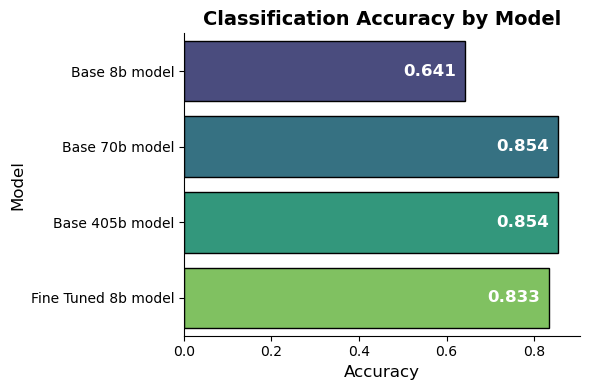

In [14]:
# Rename dictionary
rename_dict = {
    'answer_base_8B': 'Base 8b model',
    'answer_base_70B': 'Base 70b model',
    'answer_base_405B': 'Base 405b model',
    'answer_ft_8B': 'Fine Tuned 8b model',
}

# Calculate accuracy for each model with renamed keys
accuracies = {}
for name in rename_dict:
    accuracy = test_df.apply(lambda row: row[name] in row['sentiment'], axis=1).mean()
    accuracies[rename_dict[name]] = accuracy

# Horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(y=list(accuracies.keys()), x=list(accuracies.values()), palette="viridis", edgecolor='black', ax=ax)

# Add labels to bars
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_width() - 0.02, 
            bar.get_y() + bar.get_height() / 2, 
            f"{list(accuracies.values())[i]:.3f}", 
            ha='right', va='center', color='white', fontsize=12, fontweight='bold')

# Set plot aesthetics
ax.set_xlim(0, max(accuracies.values()) + 0.05)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Classification Accuracy by Model', fontsize=14, fontweight='bold')
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()